# Importing Packages

In [24]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from pathlib import Path

# Loading Data

In [11]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

In [12]:
df = pd.read_pickle(PROCESSED_DIR / 'football_model_processed.pickle')
df

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,shot_outcome_encoded,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,...,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,0,108.1,31.2,14.800338,12.831602,17.477128,...,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,1,110.9,42.6,9.464143,11.241441,9.207063,...,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,0,117.9,29.1,11.100450,7.212489,15.047259,...,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,1,101.8,27.6,22.022716,20.044949,24.498980,...,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,...,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,...,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,0,103.0,51.3,20.412986,22.871161,18.501081,...,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,0,103.8,51.4,19.809089,22.351734,17.810109,...,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,...,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


# Preparing the data

In [13]:
# ==============================  
# Train and test split
# ==============================
X = df.drop(columns = {'shot_outcome_encoded'})
y = df['shot_outcome_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

# Training the model

In [18]:
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt', 'log2']
}

# -----------------------------
# Create Random Forest classifier
# -----------------------------
rf = RandomForestClassifier(
    random_state=123,
    n_jobs=-1
)

# -----------------------------
# GridSearchCV
# -----------------------------
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [19]:
print("Starting GridSearchCV training (Random Forest)...")
grid_search_rf.fit(X_train, y_train)
print("GridSearchCV training completed.")

print("Best parameters: ", grid_search_rf.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search_rf.best_score_)

Starting GridSearchCV training (Random Forest)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  11.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  11.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  11.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  11.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  11.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  19.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  20.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  20.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  17.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=20, n_estimators=100; total tim

In [20]:
best_model = grid_search_rf.best_estimator_

In [33]:
best_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=20,
    max_features='log2',
    random_state=123,
    n_jobs=-1
)

best_model = best_model.fit(X_train, y_train)

# Evaluating the model


Test Set Performance (Random Forest):

Test AUC: 0.8020

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10216
           1       0.67      0.08      0.15      1081

    accuracy                           0.91     11297
   macro avg       0.79      0.54      0.55     11297
weighted avg       0.89      0.91      0.87     11297


Confusion Matrix:
[[10172    44]
 [  990    91]]


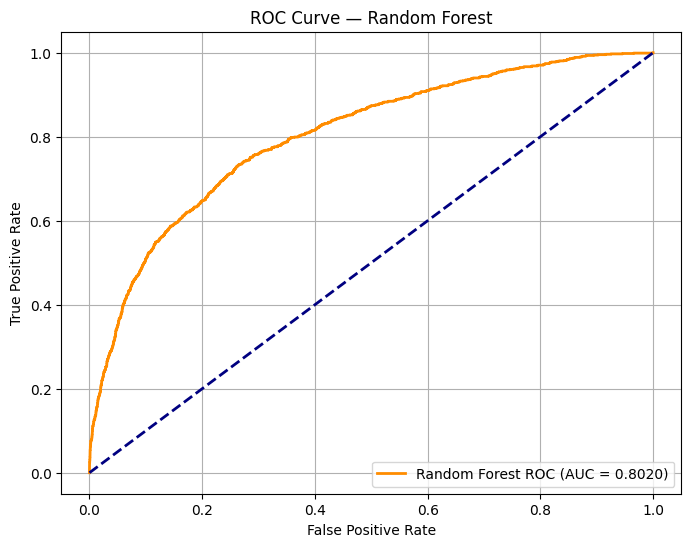

In [34]:
print("\n" + "="*50)
print("Test Set Performance (Random Forest):")
print("="*50)

y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calibration Curve

In [35]:
import numpy as np
evaluation = pd.DataFrame(y_test_pred_proba, y_test).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

In [36]:
from sklearn.metrics import brier_score_loss

# Compute Brier score for the test set predictions
brier_score = brier_score_loss(y_test, y_test_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0724


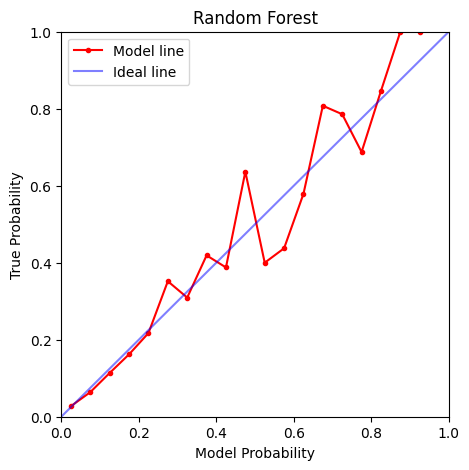

In [38]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.figure(figsize=(5, 5))

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.title("Random Forest")
plt.show()

## Isotonic Regression

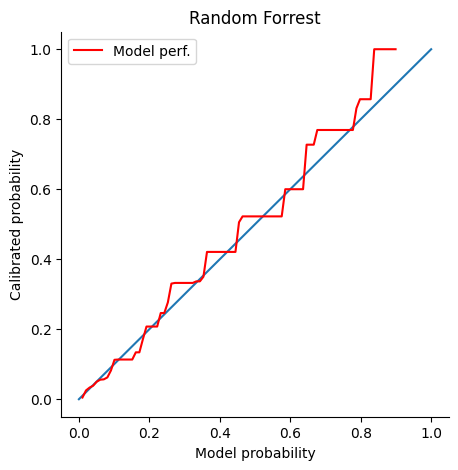

In [31]:
import sklearn.isotonic as sk_i
import seaborn as sns
i_r = sk_i.IsotonicRegression().fit(evaluation["pred_prob"], evaluation["outcome"])

model_probs = np.linspace(0, 1, num=100)

calibrated_probs = i_r.predict(model_probs)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])

plt.plot(model_probs, calibrated_probs, color='red', label = "Model perf.")

plt.legend()

plt.title("Random Forrest")
plt.xlabel('Model probability')
plt.ylabel('Calibrated probability')

sns.despine()